# FuzzyWuzzy Evaluation

FuzzyWuzzy is a python package that computes a score for approximate question similarity. It has proven to be effective in matching short textual phrases that have been slightly rearranged. 

In this notebook, we evaluate the usefulness of FuzzyWuzzy for the Quora Question Similarity Problem. 

First, import the required libraries and read the data from disk.

In [1]:
%matplotlib inline
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

dataset = pd.read_csv('../data/train.csv')
dataset.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


FuzzyWuzzy defines a ratio method that takes in two strings, and outputs a score from 0 to 100. 100 being a perfect match, and 0 being a total mismatch. Some examples are shown below.

In [2]:
print('Score of <a big cat>, <a big cat> is {0}'.format(fuzz.ratio('a big cat', 'a big cat')))
print('Score of <a big cat>, <frog bog dog> is {0}'.format(fuzz.ratio('a big cat', 'frog bog dog')))
print('Score of <a big cat>, <a big feline> is {0}'.format(fuzz.ratio('a big cat', 'a big feline')))
print('Score of <a big cat>, <a big dog> is {0}'.format(fuzz.ratio('a big cat', 'a big dog')))

Score of <a big cat>, <a big cat> is 100
Score of <a big cat>, <frog bog dog> is 38
Score of <a big cat>, <a big feline> is 57
Score of <a big cat>, <a big dog> is 67


So, fuzzywuzzy will be useful for detecting added / missing words, but it has no language processing capabilities (as illustrated by the feline example above). Let's compute the fuzzy score for each of the questions in the dataset.

In [3]:
#There's apparently a null row in the dataset. 
def safe_fuzz(t1, t2):
    try:
        return fuzz.ratio(t1, t2)
    except:
        return 0
    
dataset['fuzz_score'] = dataset.apply(lambda r: safe_fuzz(r['question1'], r['question2']), axis=1)
dataset.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,fuzz_score
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,93
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,65


Let's see if there is any correlation with fuzz score and duplicate status.

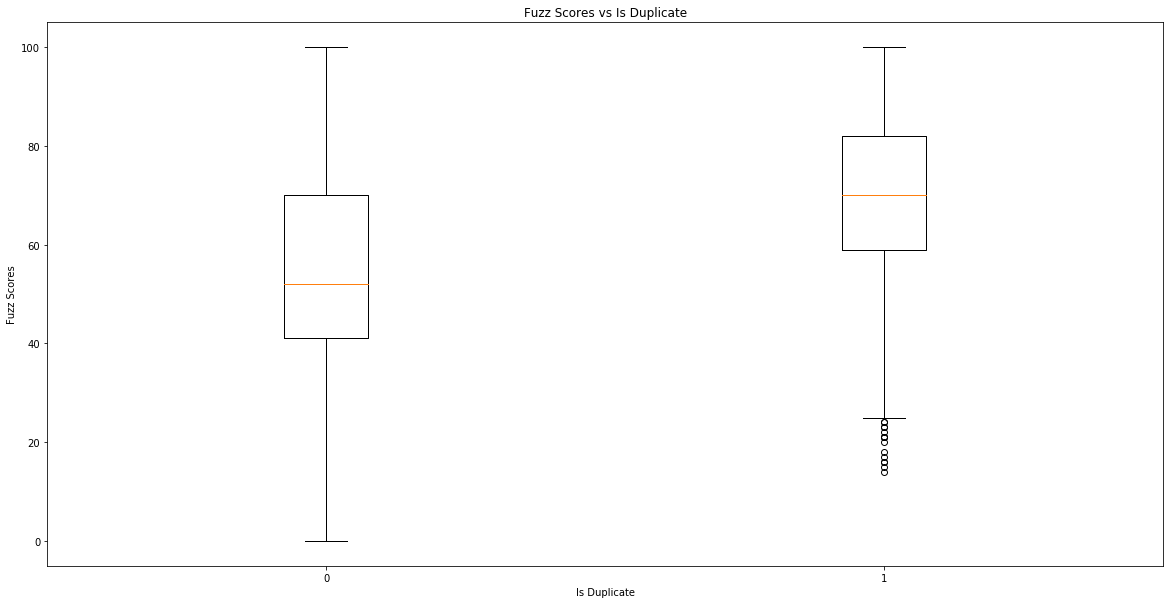

In [6]:
data_zero = list(dataset[dataset['is_duplicate'] == 0]['fuzz_score'])
data_one = list(dataset[dataset['is_duplicate'] == 1]['fuzz_score'])

fig = plt.figure(figsize=(20, 10))
plt.xlabel('Is Duplicate')
plt.ylabel('Fuzz Scores')
plt.title('Fuzz Scores vs Is Duplicate')
plt.boxplot([data_zero, data_one])
plt.xticks([1, 2], [0, 1])

plt.show()
print() #to get rid of matplotlib vomit

The results show a little correlation. Notice how there are a lot of questions that are not duplicates but have a high fuzz score. That seems a bit odd. Let's examine these more closely:

In [5]:
high_score_non_duplicate = dataset[ (dataset['is_duplicate'] == 0) & (dataset['fuzz_score'] > 95) ]
pd.set_option('display.max_colwidth', -1)
print('The number of non-duplicate question pairs with a high fuzz score is {0}'.format(high_score_non_duplicate.shape[0]))
print('The top 20 rows:')
high_score_non_duplicate.head(20)

The number of non-duplicate question pairs with a high fuzz score is 3482
The top 20 rows:


,id,qid1,qid2,question1,question2,is_duplicate,fuzz_score
14,14,29,30,"What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?",What are the laws to change your status from a student visa to a green card in the US? How do they compare to the immigration laws in Japan?,0,96
41,41,83,84,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,0,97
42,42,85,86,"Can I make 50,000 a month by day trading?","Can I make 30,000 a month by day trading?",0,98
89,89,179,180,What is your review of The Next Warrior: Proving Grounds - Part 9?,What is your review of The Next Warrior: Proving Grounds - Part 5?,0,98
145,145,291,292,Does Fab currently offer new employees stock options or RSUs?,Does Uber currently offer new employees stock options or RSUs?,0,96
298,298,596,597,On what online platforms can I post ads for beer money opportunity?,What online platforms can I post ads for beer money opportunity?,0,96
496,496,990,991,Which are the major highways in California and how are they compared to the major highways in Tennessee?,Which are the major highways in California and how are they compared to the major highways in Texas?,0,96
585,585,1168,1169,Can you play Asian Playstation 4 games on a European Playstation?,Can you play Asian Playstation 4 games on a European Playstation 4?,0,98
712,712,1420,1421,What behavioral adaptations do pandas have?,What behavioral adaptations do red pandas have?,0,96
976,976,1947,1948,"What are the main imports and exports of Venezuela, and how does Venezuela's industry compare to Cuba's?","What are the main imports and exports of Venezuela, and how does Venezuela's industry compare to Bolivia's?",0,96


Ignoring a few mislabeled questions, we see that the sentences are exactly the same, besided a word or two. Most noticebly, it appears to be a key noun or verb that is different. This will be difficult for a standard word embedding model to pick up on as these words won't appear very often in any corpus. 

# Conclusion

FuzzyWuzzy is a tool that performs simple text-based analysis. It does not have any language understanding capabilities. While the output shows some correlation with the desired labels, it is not able to capture intent of the question, thus it is not sufficient (and probably not even useful as a feature) for this kaggle problem.

While the tool is not useful, we discovered an important class of problems that our model will need to perform well on: questions that have just a single word changed, most likely one of the noun phrases in the question.